# Telco Customer Churn Analysis and Prediction

This script aims to analyze and predict customer churn for a telecommunications company. The dataset used in this project contains information about customers, including demographic factors, services subscribed to, and churn status.

The main objectives of the project are as follows:
1. Exploratory Data Analysis (EDA): Understand the characteristics and patterns present in the dataset through visualizations and descriptive statistics.
2. Feature Engineering: Create new features and preprocess the data to prepare it for modeling.
3. Model Building: Train and evaluate various machine learning models to predict customer churn. Models such as Logistic Regression, Support Vector Machines (SVM), Decision Trees, and Random Forests will be considered.
4. Model Interpretability: Use SHAP (SHapley Additive exPlanations) to explain the predictions of the best-performing model and understand the factors driving churn.
5. Hyperparameter Tuning: Optimize the parameters of the chosen models using GridSearchCV to improve performance.
6. Model Comparison: Compare the performance of different models using evaluation metrics such as accuracy, precision, recall, and F1-score.
7. Visualization: Visualize the results of the analysis, including model evaluation metrics, confusion matrices, and SHAP summary plots.

The project aims to provide insights into factors influencing customer churn and develop a predictive model that can help the telecommunications company identify customers at risk of churn and take proactive measures to retain them.

Dataset Source: https://www.kaggle.com/blastchar/telco-customer-churn

In [236]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Data Collection

In [237]:
# Load the dataset
data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [238]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## General analysis of data

In [239]:
data.shape

(7043, 21)

In [240]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [241]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [242]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Analysis of each variable and its connection with the target

In [243]:
# Feature Engineering: Creating a new feature representing the ratio of MonthlyCharges to TotalCharges
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].mean())
data['MonthlyTotalRatio'] = data['MonthlyCharges'] / (data['TotalCharges'] + 1)

In [244]:
# Define categorical and continuous columns
categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
continuous_columns = ['tenure', 'MonthlyCharges', 'TotalCharges', 'MonthlyTotalRatio']

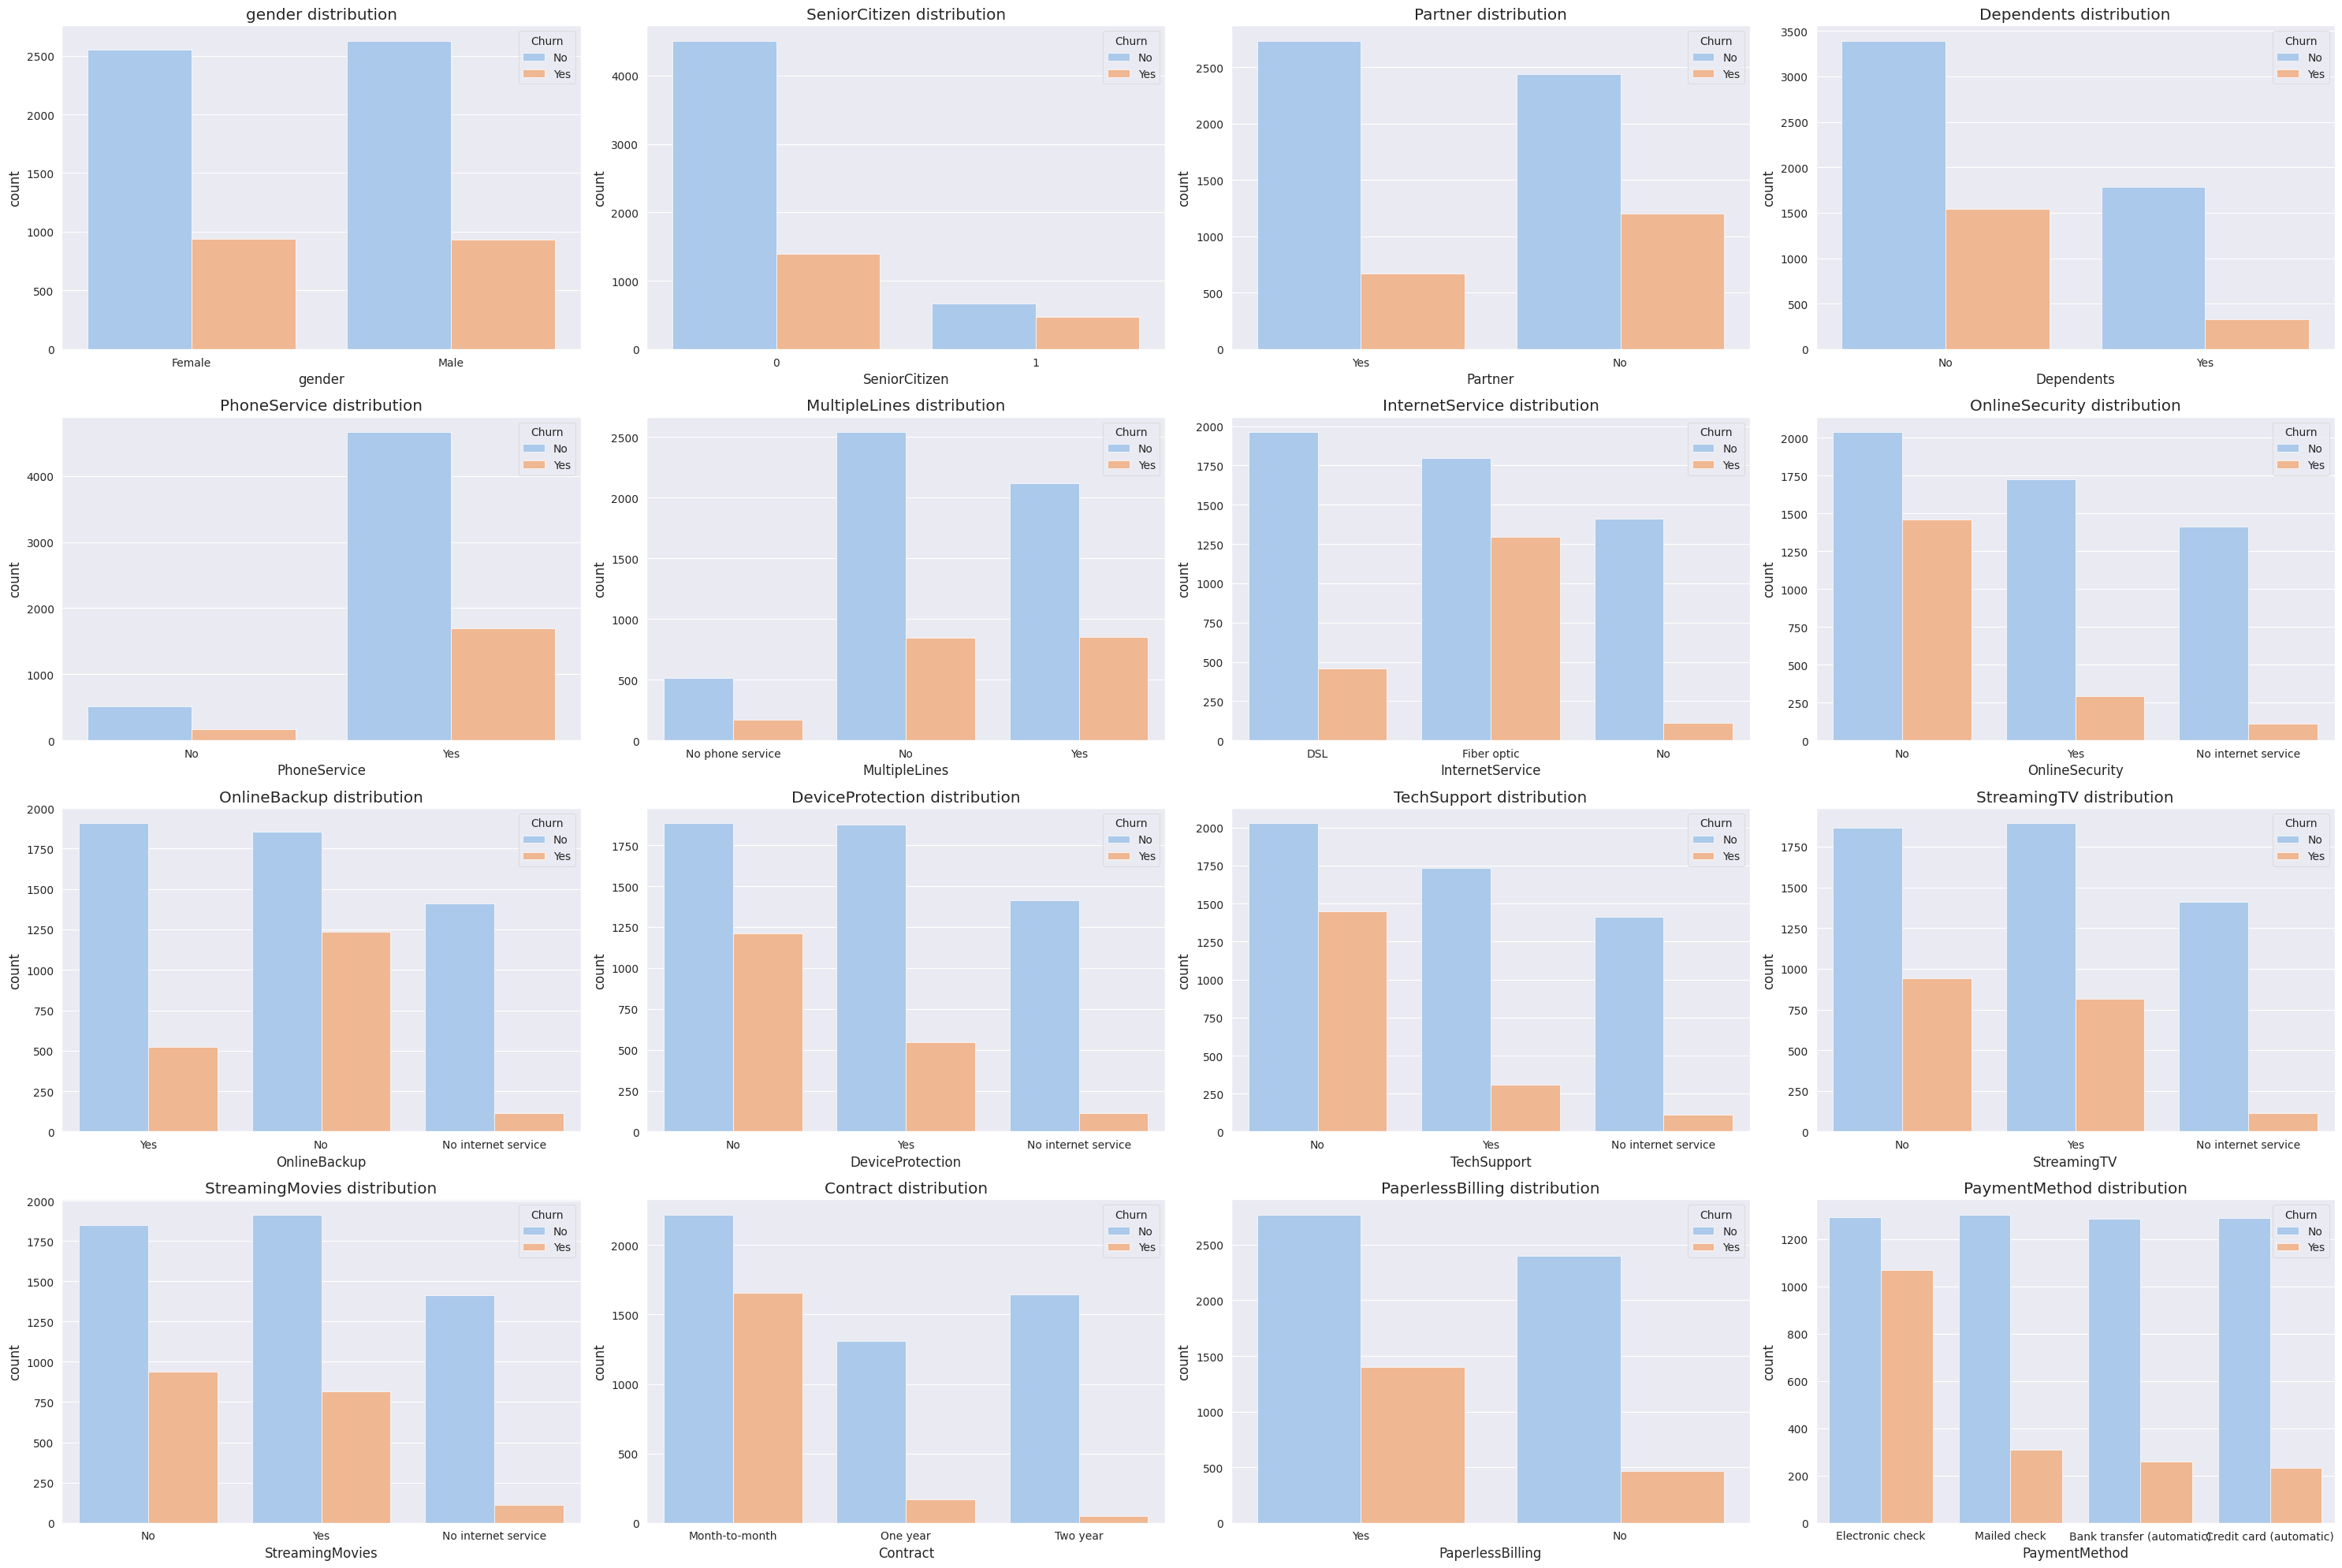

In [245]:
# Visualize the distribution of each categorical variable with respect to the target variable
sns.set_style('darkgrid')
sns.set_palette('pastel')
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(30, 20))

for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, data=data, ax=ax[i // 4, i % 4], hue='Churn')
    ax[i // 4, i % 4].set_title(f'{column} distribution')

plt.tight_layout()
plt.show()

In [246]:
data[continuous_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tenure             7043 non-null   int64  
 1   MonthlyCharges     7043 non-null   float64
 2   TotalCharges       7043 non-null   float64
 3   MonthlyTotalRatio  7043 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 220.2 KB


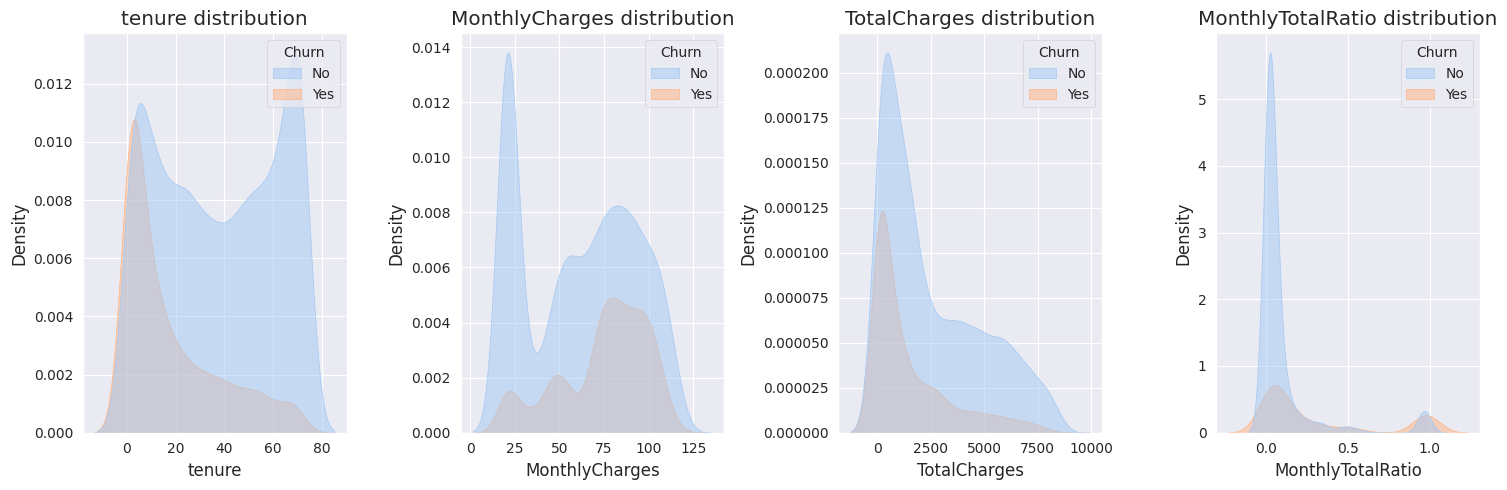

In [247]:
# Visualize the distribution of each continuous variable with respect to the target variable
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

for i, column in enumerate(continuous_columns):
  sns.kdeplot(data=data, x=column, hue="Churn", fill=True, alpha=0.5, ax=ax[i])
  ax[i].set_title(f'{column} distribution')

plt.tight_layout()
plt.show()

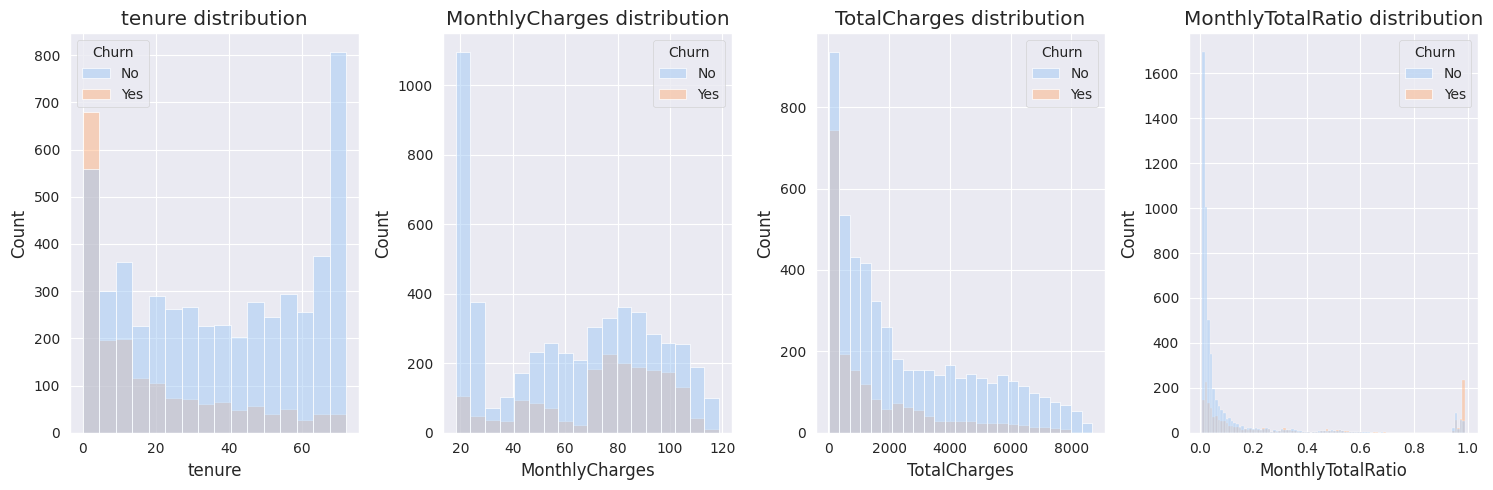

In [248]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

for i, column in enumerate(continuous_columns):
  sns.histplot(data=data, x=column, hue="Churn", alpha=0.5, ax=ax[i])
  ax[i].set_title(f'{column} distribution')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [249]:
data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
Churn                0
MonthlyTotalRatio    0
dtype: int64

In [250]:
X = data.drop(['Churn', 'customerID'], axis=1)
y = data['Churn']

In [251]:
label_encoders = {col: LabelEncoder() for col in categorical_columns}
X = X.apply(lambda col: label_encoders[col.name].fit_transform(col) if col.name in label_encoders else col)

In [252]:
label_encoders['Churn'] = LabelEncoder()
y = label_encoders['Churn'].fit_transform(y)

In [253]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [254]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [255]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MonthlyTotalRatio
4541,0,1,0,0,1,1,2,0,0,0,0,0,0,0,0,0,3,50.550000,50.550000,0.980601
5709,0,0,0,0,12,1,0,2,1,1,1,1,1,1,1,0,3,19.300000,228.750000,0.084004
7393,0,0,0,0,7,1,0,1,1,0,0,0,0,0,0,0,0,76.081609,501.701368,0.151344
10026,0,0,0,0,13,1,2,1,0,0,0,0,2,1,0,1,2,93.906654,1293.699061,0.072538
3578,0,0,0,0,40,1,0,0,2,2,0,0,2,0,0,0,3,65.100000,2586.000000,0.025164


## Logistic Regression

In [256]:
model_logistic = LogisticRegression(max_iter=10000)
model_logistic.fit(X_train, y_train)
y_pred_logistic = model_logistic.predict(X_test)

## SVM classifier

In [257]:
model_svm = SVC()
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)

## Desicion Tree Classifier

In [258]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)

In [259]:
# Hyperparameter Tuning for Decision Tree Classifier
parameters = {'max_depth': [2, 3, 4, 5, 6, 7], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(model_dt, parameters, cv=5)
grid_search.fit(X_train, y_train)
best_model_dt = grid_search.best_estimator_
y_pred_best_dt = best_model_dt.predict(X_test)

## Random Forest

In [260]:
parameters = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search_rf = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
grid_search_rf.fit(X_train, y_train)
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)

## Model Evaluation

In [261]:
models = {
    'Logistic Regression': (model_logistic, y_pred_logistic),
    'SVM Classifier': (model_svm, y_pred_svm),
    'Decision Tree Classifier': (model_dt, y_pred_dt),
    'Tuned Decision Tree Classifier': (best_model_dt, y_pred_best_dt),
    'Random Forest': (best_model_rf, y_pred_rf)
}

In [262]:
for name, (model, y_pred) in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f'\n{name}:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1}')
    print(f'Confusion Matrix:\n{cm}')


Logistic Regression:
Accuracy: 0.8135265700483092
Precision: 0.7865168539325843
Recall: 0.8674928503336511
F1-score: 0.8250226654578423
Confusion Matrix:
[[774 247]
 [139 910]]

SVM Classifier:
Accuracy: 0.6516908212560386
Precision: 0.6806167400881057
Recall: 0.5891325071496664
F1-score: 0.631578947368421
Confusion Matrix:
[[731 290]
 [431 618]]

Decision Tree Classifier:
Accuracy: 0.8043478260869565
Precision: 0.803201506591337
Recall: 0.8131553860819828
F1-score: 0.808147797252487
Confusion Matrix:
[[812 209]
 [196 853]]

Tuned Decision Tree Classifier:
Accuracy: 0.8183574879227054
Precision: 0.8061874431301183
Recall: 0.8446139180171592
F1-score: 0.824953445065177
Confusion Matrix:
[[808 213]
 [163 886]]

Random Forest:
Accuracy: 0.8396135265700483
Precision: 0.8198037466547725
Recall: 0.8760724499523356
F1-score: 0.8470046082949308
Confusion Matrix:
[[819 202]
 [130 919]]
